In [117]:
import warnings

warnings.filterwarnings('ignore')

from os.path import join
import gym
import pandas as pd
import ray.rllib.models.preprocessors as rllib_preprocessor
from gym_platform.envs.platform_env import Constants, ENEMY_PATH
import seaborn as sns
from src.files.utills import load_obj
from src.rllib_utills.preprocessor import _get_preprocessor

# Setup

Load data and perform basic setup for the analysis.

In [118]:
rllib_preprocessor.get_preprocessor = _get_preprocessor
sns.set(style="white", palette=None)


env_name = "Platform-v0"
env = gym.make(env_name)
results_df = load_obj(join('tmp', 'evaluation_results.pkl')).reset_index()

# Flatten and Split

The observations and actions in the dataset consist of tuple having categorical and continuous values. Each feature in these action/observation tuples are split into their separate columns.

In [119]:
def flatten_column(df, column_name, gym_space):
    col_preprocessor = rllib_preprocessor.get_preprocessor(gym_space)(gym_space)
    df[column_name] = df[column_name].apply(lambda x: col_preprocessor.transform(x))
    return df


def split_column(df, column_name, seperated_column_names):
    split = pd.DataFrame(df[column_name].to_list(), columns=seperated_column_names)
    df = pd.concat([df, split], axis=1)
    return df

action_parameters = ['run', 'hop', 'leap']
actions_labels = ['action_idx'] + action_parameters
basic_features = ['player_pos', 'player_vel', 'enemy_pos', 'enemy_vel']
platform_features = ['pos', 'wd1', 'wd2', 'gap', 'diff']
feature_labels = basic_features + platform_features + ['step']
results_df = flatten_column(df=results_df, column_name='actions', gym_space=env.action_space)
results_df = split_column(df=results_df, column_name='actions', seperated_column_names=actions_labels)
results_df = flatten_column(df=results_df, column_name='observations', gym_space=env.observation_space)
results_df = split_column(df=results_df, column_name='observations', seperated_column_names=feature_labels)

# Scale and Label Actions

Each action value has a very different scale. The action values are scaled between 0-1 to make easier to visualize.

In [120]:

results_df[action_parameters] = (results_df[action_parameters] - Constants.PARAMETERS_MIN) / (
        Constants.PARAMETERS_MAX - Constants.PARAMETERS_MIN)
results_df['action'] = results_df['action_idx'].apply(lambda x: action_parameters[int(x)])


# Anomalies

Although the policy converged during training but still some percentage of episodes still may fail. Those episodes are detected and the differences between the failed and the passed episodes are shown.

,Episode Successful,ep_id,rewards
0,False,2,2
1,True,998,998


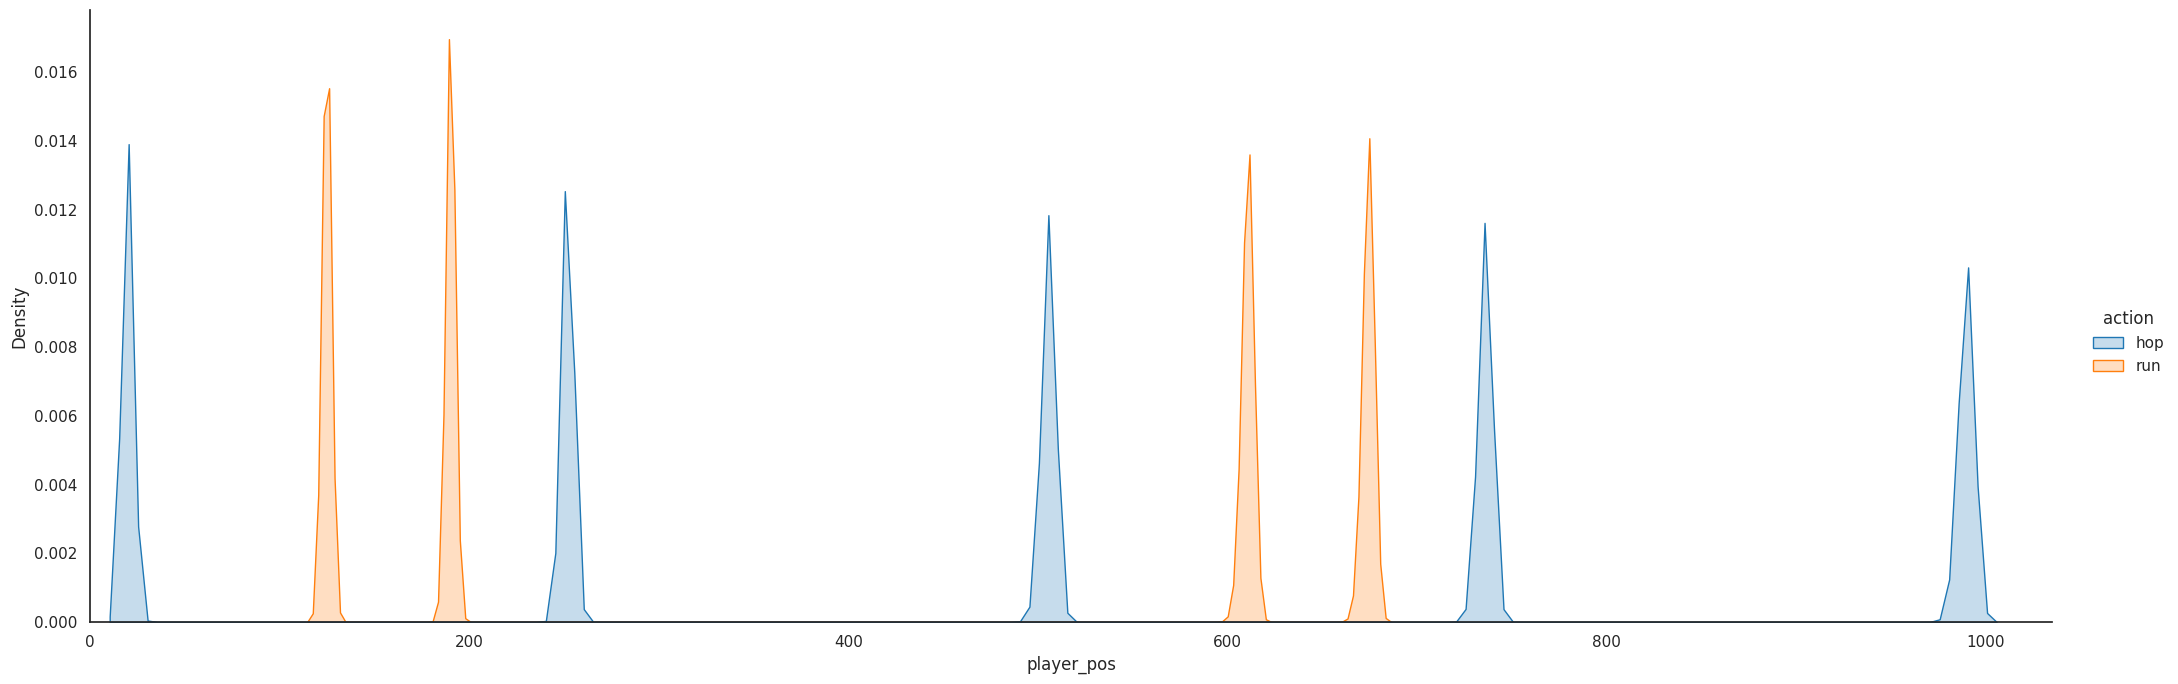

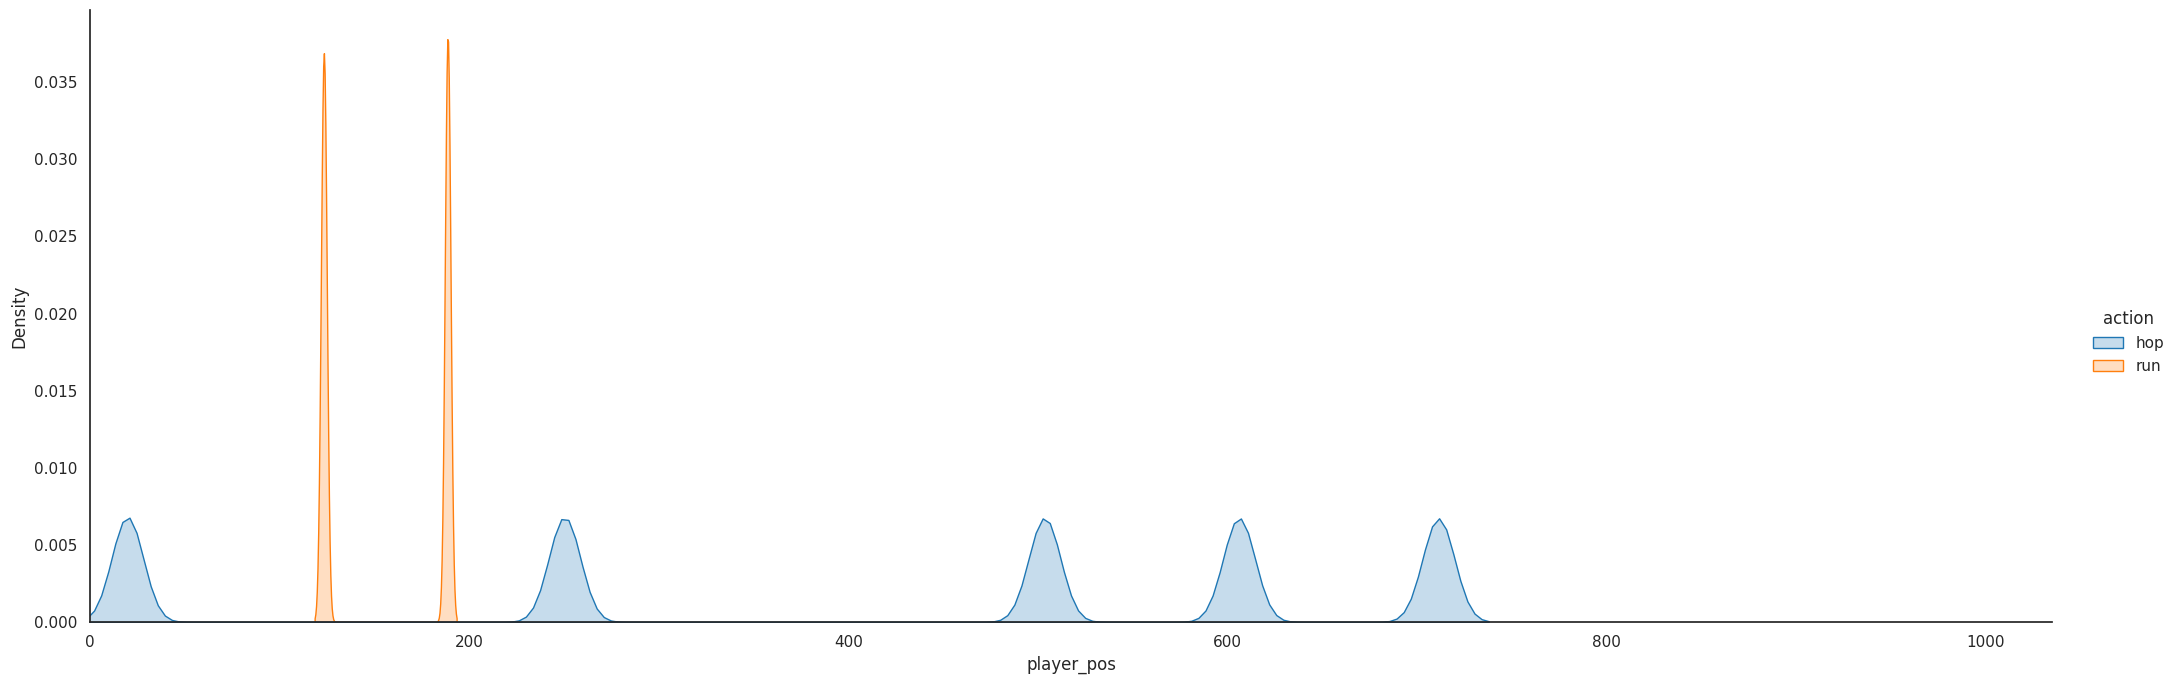

In [121]:
rewards_sums = results_df.groupby('ep_id')['rewards'].sum().reset_index()

#sns.displot(rewards_sums, x="rewards", kind="hist", fill=True)
rewards_sums['Episode Successful'] = rewards_sums['rewards']>=.98
successful_counts = rewards_sums.groupby('Episode Successful').count().reset_index()
failed_episodes = rewards_sums[rewards_sums['Episode Successful']==False]['ep_id'].unique()
failed_ep_filter = results_df['ep_id'].isin(failed_episodes)
passed_ep_filter = ~failed_ep_filter


platform_range = [0,Constants.TOTAL_WIDTH]
tmp_results_df = results_df.copy()
tmp_results_df['player_pos'] *= Constants.TOTAL_WIDTH



sns.displot(data=tmp_results_df[passed_ep_filter], x="player_pos", hue="action", kind="kde",bw_adjust=.05, fill=True,facet_kws={'xlim': platform_range},height=7, aspect=3)
sns.displot(data=tmp_results_df[failed_ep_filter], x="player_pos", hue="action", kind="kde",bw_adjust=.05, fill=True,facet_kws={'xlim': platform_range},height=7, aspect=3)
successful_counts

# Agent Behaviour Near Enemy

The actions that the agent take near enemies are visualized.

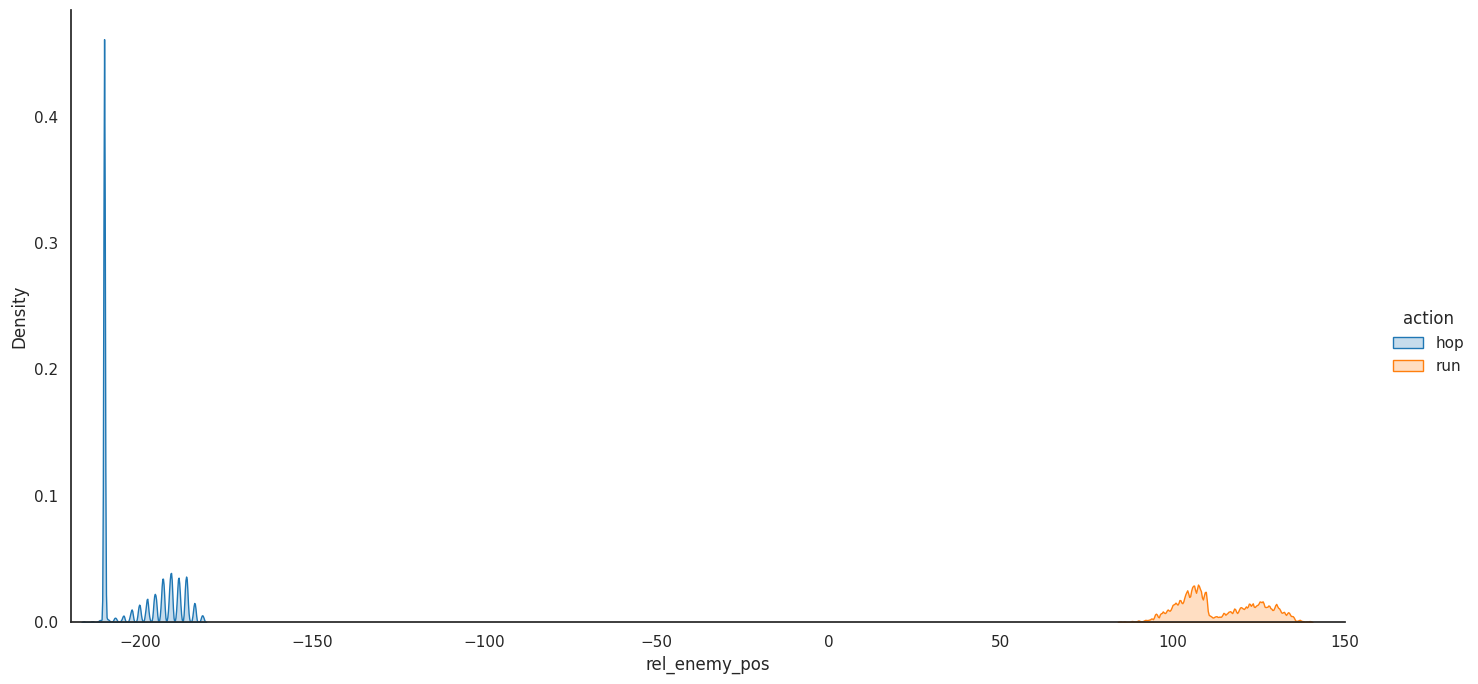

In [122]:
close_enemy_range = [-220, 150]
results_df['rel_enemy_pos'] = (results_df['player_pos'] - results_df['enemy_pos']) * Constants.TOTAL_WIDTH
close_to_enemy_filter = (results_df['rel_enemy_pos'] > close_enemy_range[0]) & (
        results_df['rel_enemy_pos'] < close_enemy_range[1]) & passed_ep_filter



sns.displot(data=results_df[close_to_enemy_filter], x="rel_enemy_pos", hue="action", kind="kde",bw_adjust=.1, fill=True,
          facet_kws={'xlim': close_enemy_range}, height=7, aspect=2)


# Action and Their Values Over Episode

The probability of specific actions taken and their values are shown over the course of the entire episode.

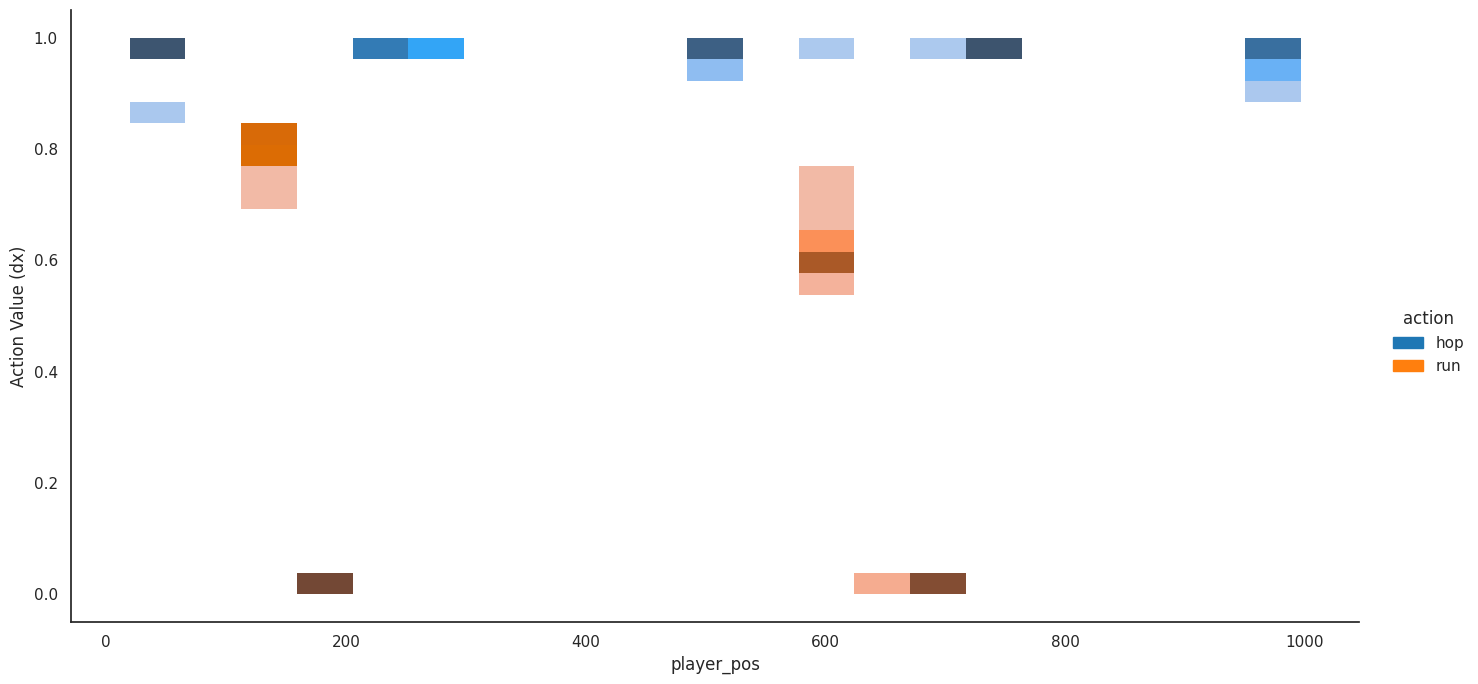

In [123]:
tmp_results_df['Action Value (dx)'] = tmp_results_df.apply(lambda row: row[row['action']], axis=1)
sns.displot(data=tmp_results_df, x='player_pos',y="Action Value (dx)", hue="action", kind="hist",height=7, aspect=2)


In [125]:
sns.displot(data=results_df, x="Action Value (dx)", hue="action", kind="hist", fill=True,height=7, aspect=2)

ValueError: Could not interpret value `Action Value (dx)` for parameter `x`

In [ ]:
results_df

# Agent Near Edges

The action taken by the agent while being near edges are shown.

In [ ]:
def rel_edge_pos(xpos):
    if xpos < Constants.WIDTH1:
        edge_pos = Constants.WIDTH1
    elif xpos < Constants.WIDTH1 + Constants.GAP1 + Constants.WIDTH2:
        edge_pos = Constants.WIDTH1 + Constants.GAP1 + Constants.WIDTH2
    else:
        edge_pos=Constants.TOTAL_WIDTH
    rel_pos =  xpos - edge_pos
    return rel_pos

def calc_platform_idx(xpos):
    if xpos < Constants.WIDTH1:
        platform_idx = 1
    elif xpos < Constants.WIDTH1 + Constants.GAP1 + Constants.WIDTH2:
        platform_idx = 2
    else:
        platform_idx = 3
    return platform_idx

edge_range = [-80, 80]
results_df['rel_edge_pos'] = (results_df['player_pos']*Constants.TOTAL_WIDTH).apply(rel_edge_pos)
results_df['platform_idx'] = (results_df['player_pos']*Constants.TOTAL_WIDTH).apply(calc_platform_idx)
near_edge_filter = (results_df['rel_edge_pos']>edge_range[0])&(results_df['rel_edge_pos']<edge_range[1])&(results_df['player_pos']<(Constants.WIDTH1 + Constants.GAP1 + Constants.WIDTH2)) & results_df['platform_idx'].isin([1,2]) & passed_ep_filter
sns.displot(data=results_df[near_edge_filter&passed_ep_filter], x="rel_edge_pos", hue="action", kind="kde",bw_adjust=.1, fill=True,
          facet_kws={'xlim': edge_range}, height=7, aspect=2)